# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]

### Member 1: [Fill in your name]

### Member 2: [Fill in your name]

### Member 3: [Fill in your name]


We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies


In [1]:
!pip show torch

zsh:1: command not found: pip


In [2]:
retrain = False #set it to True, if you wanna train your models fresh

In [3]:
# print(

In [4]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip


In [ ]:
np.random.seed(0)
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Draw
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader  # correct one for SMILES
from torch.utils.data import DataLoader as BigDataLoader
from torch.utils.data import Dataset, Subset
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from tqdm import tqdm

RDLogger.DisableLog('rdApp.*')

In [ ]:
with open('pos_data.pkl', 'rb') as f:
    pos_data = pickle.load(f)

with open('type_data.pkl', 'rb') as f:
    type_data = pickle.load(f)

with open('smiles.pkl', 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load('data_split.npz')

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

formation_energy = np.load('formation_energy.npz')

fe = formation_energy['y'] # normalized formation energy
mu = formation_energy['mu']
std = formation_energy['sigma']

In [9]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 119012, test: 10000, sum: 129012


In [10]:
# Example molecule at index 0
positions = pos_data[0]
atom_types = type_data[0]

print("Atom Types:", atom_types)
print("Positions:\n", positions)

Atom Types: [6 1 1 1 1]
Positions:
 [[-1.2700e-02  1.0858e+00  8.0000e-03]
 [ 2.2000e-03 -6.0000e-03  2.0000e-03]
 [ 1.0117e+00  1.4638e+00  3.0000e-04]
 [-5.4080e-01  1.4475e+00 -8.7660e-01]
 [-5.2380e-01  1.4379e+00  9.0640e-01]]


In [ ]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


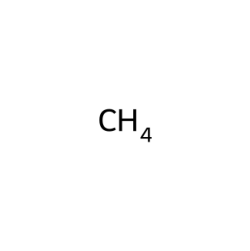

In [12]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.083│     1.598│     0.056
  C  │  6   │    -0.025│     0.089│     0.015
  C  │  6   │     1.040│    -0.708│    -0.933
  C  │  6   │     0.656│    -1.874│     0.074
  C  │  6   │     1.038│    -2.794│     1.262
  O  │  8   │     0.412│    -1.802│     2.169
  C  │  6   │     0.692│    -0.809│     1.125
  C  │  6   │    -0.853│    -1.985│    -0.218
  C  │  6   │    -1.283│    -0.726│    -0.270
  H  │  1   │     0.888│     2.026│     0.322
  H  │  1   │    -0.374│     2.008│    -0.918
  H  │  1   │    -0.817│     1.940│     0.794
  H  │  1   │     0.735│    -0.825│    -1.976
  H  │  1   │     2.066│    -0.338│    -0.857
  H  │  1   │     0.541│    -3.765│     1.333
  H  │  1   │     2.110│    -2.886│     1.472
  H  │  1   │     1.683│    -0.386│     1.340
  H  │  1   │    -1.384│    -2.917│    -0.354
  H  │  1   │    -2.268│    -0.324│    -0.457


SMILE: C[C@]12C=C[C@@]3(CO[C@@H]

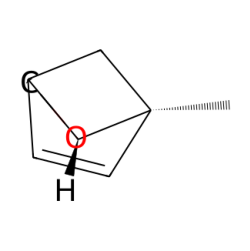

In [13]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

## Task 1


## Task 1 - Building a model for geometric molecular representations

a. Converting Geometric representation of data (type_data and pos_data) into PyG-compatible Data objects


In [ ]:
class MoleculeGraphDataset(Dataset):
    def __init__(self, pos_data, type_data, fe_targets, idxes, radius=3.0):
        super().__init__()
        self.pos_data = pos_data
        self.type_data = type_data
        self.targets = fe_targets
        self.idxes = idxes
        self.radius = radius
        self.encoder = OneHotEncoder(sparse_output=False)
        self.encoder.fit(np.array([[1], [6], [7], [8], [9], [16]])) 

    def len(self):
        return len(self.idxes)

    def get(self, idx):
        real_idx = self.idxes[idx]
        pos = self.pos_data[real_idx]
        atom_types = self.type_data[real_idx].reshape(-1, 1)
        x = torch.tensor(self.encoder.transform(atom_types), dtype=torch.float) 
        pos = torch.tensor(pos, dtype=torch.float)

        tree = cKDTree(pos)
        #fixing set to integer issue
        pairs = list(tree.query_pairs(r=self.radius))
        if len(pairs) > 0:
            edge_index = torch.tensor(pairs, dtype=torch.long).T
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # make bidirectional
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        y = torch.tensor(self.targets[real_idx], dtype=torch.float).view(1)

        return Data(x=x, edge_index=edge_index, pos=pos, y=y)


/Users/aniket/Environments/env_312_tue_ml/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aniket/Environments/env_312_tue_ml/lib/python3.12/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN5torch3jit17parseSchemaOrNameERKNSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEE
  Referenced from: <88720416-EFED-3E33-BAF5-A9444CF3FDAB> /Users/aniket/Environments/env_312_tue_ml/lib/python3.12/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <DA215AD3-6EAE-3755-B6A5-A8EB4EF952B0> /Users/aniket/Environments/env_312_tue_ml/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aniket/Environments/env_312_tue_ml/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling it

In [ ]:
train_dataset = MoleculeGraphDataset(pos_data, type_data, fe, train_idxes)
test_dataset = MoleculeGraphDataset(pos_data, type_data, fe, test_idxes)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


Buildin GNN Model


In [ ]:
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch) 
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x.view(-1) 


Training the model


In [ ]:
#training and evaluating

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1))
        total_loss += loss.item() * batch.num_graphs
        preds.extend(out.cpu().numpy())
        targets.extend(batch.y.view(-1).cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, preds, targets


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if retrain:
    model = GCNModel(in_channels=6, hidden_channels=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(1, 21):
        train_loss = train()
        test_loss, preds_x, targets_x = evaluate(test_loader)
        print(f"Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    torch.save(model.state_dict(), 'gcn_model_weights.pt')
    print("Model weights saved to gcn_model_weights.pt")

else:
    model = GCNModel(in_channels=6, hidden_channels=64).to(device)
    model.load_state_dict(torch.load('gcn_model_weights.pt'))
    model.eval()
    criterion = torch.nn.MSELoss()

In [22]:
train_loss, train_preds, train_targets = evaluate(train_loader)
test_loss, test_preds, test_targets = evaluate(test_loader)

In [ ]:
#Unnormalizing
train_preds = np.array(train_preds) * std + mu
train_targets = np.array(train_targets) * std + mu

test_preds = np.array(test_preds) * std + mu
test_targets = np.array(test_targets) * std + mu


In [ ]:
#Compute mse and mae
train_mae = mean_absolute_error(train_targets, train_preds)
train_mse = mean_squared_error(train_targets, train_preds)

test_mae = mean_absolute_error(test_targets, test_preds)
test_mse = mean_squared_error(test_targets, test_preds)

print(f"GCN Model - Train MAE: {train_mae:.2f}, MSE: {train_mse:.2f}")
print(f"GCN Model - Test MAE: {test_mae:.2f}, MSE: {test_mse:.2f}")


GCN Model - Train MAE: 2.71, MSE: 18.05
GCN Model - Test MAE: 2.75, MSE: 18.54


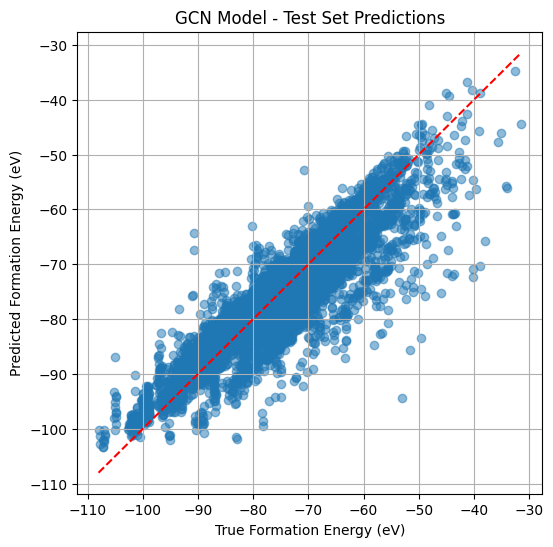

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(test_targets, test_preds, alpha=0.5)
plt.plot([min(test_targets), max(test_targets)],
         [min(test_targets), max(test_targets)], 'r--')
plt.xlabel("True Formation Energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.title("GCN Model - Test Set Predictions")
plt.grid(True)
plt.savefig("gcn_predictions_vs_true.png")
plt.show()


## Task 1 - Building a model for SMILES molecular representations

a.


In [ ]:
class SMILESTokenizer:
    def __init__(self, smiles_list):
        chars = set("".join(smiles_list))
        self.char2idx = {ch: i + 1 for i, ch in enumerate(sorted(chars))}
        self.char2idx["<PAD>"] = 0
        self.idx2char = {i: ch for ch, i in self.char2idx.items()}

    def encode(self, smile):
        return torch.tensor([self.char2idx[ch] for ch in smile], dtype=torch.long)

    def pad_batch(self, batch):
        return pad_sequence(batch, batch_first=True, padding_value=0)


In [ ]:
class SMILESDataset(Dataset):
    def __init__(self, smiles_list, fe_list, idx_list, tokenizer):
        self.smiles = [tokenizer.encode(smiles_list[i]) for i in idx_list]
        self.fe = torch.tensor([fe[i] for i in idx_list], dtype=torch.float)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.fe)

    def __getitem__(self, idx):
        return self.smiles[idx], self.fe[idx]


In [ ]:
class SMILESModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        h = h_n.squeeze(0)
        h = torch.relu(self.lin1(h))
        return self.lin2(h).squeeze(1)


In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for smiles, targets in dataloader:
        smiles = tokenizer.pad_batch(smiles).to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output = model(smiles)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * smiles.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    preds, targets_all = [], []
    with torch.no_grad():
        for smiles, targets in dataloader:
            smiles = tokenizer.pad_batch(smiles).to(device)
            targets = targets.to(device)
            output = model(smiles)
            loss = criterion(output, targets)
            total_loss += loss.item() * smiles.size(0)
            preds.extend(output.cpu().numpy())
            targets_all.extend(targets.cpu().numpy())
    return total_loss / len(dataloader.dataset), preds, targets_all


In [ ]:

# Tokenizer
tokenizer = SMILESTokenizer(smiles_data)

def collate_fn(batch):
    smiles_batch, target_batch = zip(*batch)
    smiles_batch = tokenizer.pad_batch(smiles_batch)
    target_batch = torch.stack(target_batch)
    return smiles_batch, target_batch

# Datasets
train_dataset = SMILESDataset(smiles_data, fe, train_idxes, tokenizer)
test_dataset = SMILESDataset(smiles_data, fe, test_idxes, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

if retrain:
    model = SMILESModel(vocab_size=len(tokenizer.char2idx)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, 21):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        test_loss, _, _ = evaluate(model, test_loader, criterion, device)
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

    torch.save(model.state_dict(), "smiles_model_weights.pt")
    print("Model weights saved to smiles_model_weights.pt")

else:
    model = SMILESModel(vocab_size=len(tokenizer.char2idx)).to(device)
    model.load_state_dict(torch.load("smiles_model_weights.pt"))
    model.eval()
    print("Loaded pretrained SMILES model weights.")


Loaded pretrained SMILES model weights.


In [33]:
train_loss, train_preds, train_targets = evaluate(model, train_loader, criterion, device)
test_loss, test_preds, test_targets = evaluate(model, test_loader, criterion, device)

In [ ]:
#unnormalize
train_preds = np.array(train_preds) * std + mu
train_targets = np.array(train_targets) * std + mu
test_preds = np.array(test_preds) * std + mu
test_targets = np.array(test_targets) * std + mu


In [ ]:
#compute mse and mae
train_mae = mean_absolute_error(train_targets, train_preds)
train_mse = mean_squared_error(train_targets, train_preds)
test_mae = mean_absolute_error(test_targets, test_preds)
test_mse = mean_squared_error(test_targets, test_preds)

print(f"SMILES Model - Train MAE: {train_mae:.2f}, MSE: {train_mse:.2f}")
print(f"SMILES Model - Test MAE: {test_mae:.2f}, MSE: {test_mse:.2f}")


SMILES Model - Train MAE: 0.28, MSE: 0.18
SMILES Model - Test MAE: 0.29, MSE: 0.20


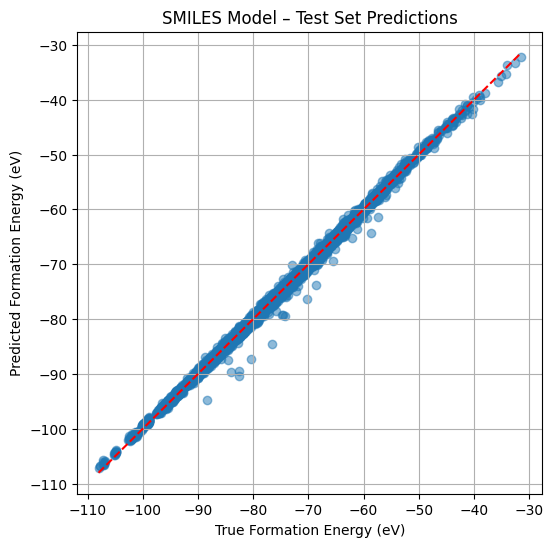

In [ ]:
#plot
plt.figure(figsize=(6, 6))
plt.scatter(test_targets, test_preds, alpha=0.5)
plt.plot([min(test_targets), max(test_targets)],
         [min(test_targets), max(test_targets)], 'r--')
plt.xlabel("True Formation Energy (eV)")
plt.ylabel("Predicted Formation Energy (eV)")
plt.title("SMILES Model – Test Set Predictions")
plt.grid(True)
plt.savefig("smiles_predictions_vs_true.png")
plt.show()


## Task 2


In [ ]:
#subset
def create_subsets(dataset, sizes, seed=42):
    random.seed(seed)
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    return {size: Subset(dataset, indices[:size]) for size in sizes}


In [38]:
def training(model, loader, optimizer, loss_fn, device, epochs=10):
    model.train()
    for _ in range(epochs):
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out.view(-1), batch.y.view(-1))
            loss.backward()
            optimizer.step()


In [ ]:
def evaluating(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds.append(out.view(-1).cpu())
            targets.append(batch.y.view(-1).cpu())
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    return mean_absolute_error(targets, preds), r2_score(targets, preds)


In [ ]:
subset_sizes = [100, 300, 1000, 3000, 10000]
gcn_train_dataset = MoleculeGraphDataset(pos_data, type_data, fe, train_idxes)
gcn_test_dataset = MoleculeGraphDataset(pos_data=pos_data,type_data=type_data,fe_targets=fe,idxes=test_idxes)
gcn_results = {}

gcn_subsets = create_subsets(gcn_train_dataset, subset_sizes)

for size, subset in gcn_subsets.items():
    print(f"\nTraining on {size} samples...")
    
    loader = DataLoader(subset, batch_size=64, shuffle=True)
    
    model = GCNModel(in_channels=6, hidden_channels=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.L1Loss()

    training(model, loader, optimizer, loss_fn, device, epochs=10)
    test_loader = DataLoader(gcn_test_dataset, batch_size=64)
    mae, r2 = evaluating(model, test_loader, device)
    gcn_results[size] = {'MAE': mae, 'R2': r2}
    print(f"Subset size: {size} | MAE: {mae:.4f} | R²: {r2:.4f}")



Training on 100 samples...
Subset size: 100 | MAE: 0.7714 | R²: 0.0440

Training on 300 samples...
Subset size: 300 | MAE: 0.6208 | R²: 0.3512

Training on 1000 samples...
Subset size: 1000 | MAE: 0.2917 | R²: 0.7590

Training on 3000 samples...
Subset size: 3000 | MAE: 0.2691 | R²: 0.7771

Training on 10000 samples...
Subset size: 10000 | MAE: 0.2629 | R²: 0.7757


SMILES


In [ ]:
def smiles_collate_fn(batch):
    sequences, targets = zip(*batch)
    sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    targets = torch.stack(targets)
    return {'x': padded, 'y': targets}


In [ ]:
def train_smiles(model, loader, optimizer, loss_fn, device, epochs=10):
    model.train()
    for _ in range(epochs):
        for batch in loader:
            x, y = batch['x'].to(device), batch['y'].to(device)
            optimizer.zero_grad()
            out = model(x).squeeze()
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()


def evaluate_smiles(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            x, y = batch['x'].to(device), batch['y'].to(device)
            out = model(x).squeeze()
            preds.append(out.cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    return mean_absolute_error(targets, preds), r2_score(targets, preds)


In [ ]:
tokenizer = SMILESTokenizer([smiles_data[i] for i in train_idxes])
smiles_train_dataset = SMILESDataset(smiles_data, fe, train_idxes, tokenizer)
smiles_test_dataset = SMILESDataset(smiles_data, fe, test_idxes, tokenizer)
subset_sizes = [100, 300, 1000, 3000, 10000]
smiles_subsets = create_subsets(smiles_train_dataset, subset_sizes)
test_loader = BigDataLoader(smiles_test_dataset, batch_size=64, collate_fn=smiles_collate_fn)

In [ ]:
smiles_results = {}

# Training loop
for size, subset in smiles_subsets.items():
    print(f"\nTraining on {size} SMILES samples...")

    loader = BigDataLoader(subset, batch_size=64, shuffle=True, collate_fn=smiles_collate_fn)

    model = SMILESModel(vocab_size=len(tokenizer.char2idx), hidden_dim=128).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.L1Loss()

    train_smiles(model, loader, optimizer, loss_fn, device, epochs=10)
    mae, r2 = evaluate_smiles(model, test_loader, device)
    smiles_results[size] = {'MAE': mae, 'R2': r2}
    print(f"Subset size: {size} | MAE: {mae:.4f} | R²: {r2:.4f}")



Training on 100 SMILES samples...


/var/folders/6y/x9npfhwj7jg8y0qjzvn6wpb80000gq/T/ipykernel_14888/1810287942.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]


Subset size: 100 | MAE: 0.7918 | R²: -0.0037

Training on 300 SMILES samples...


/var/folders/6y/x9npfhwj7jg8y0qjzvn6wpb80000gq/T/ipykernel_14888/1810287942.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]


Subset size: 300 | MAE: 0.7933 | R²: -0.0057

Training on 1000 SMILES samples...


/var/folders/6y/x9npfhwj7jg8y0qjzvn6wpb80000gq/T/ipykernel_14888/1810287942.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]


Subset size: 1000 | MAE: 0.5371 | R²: 0.5590

Training on 3000 SMILES samples...


/var/folders/6y/x9npfhwj7jg8y0qjzvn6wpb80000gq/T/ipykernel_14888/1810287942.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]


Subset size: 3000 | MAE: 0.3149 | R²: 0.8247

Training on 10000 SMILES samples...


/var/folders/6y/x9npfhwj7jg8y0qjzvn6wpb80000gq/T/ipykernel_14888/1810287942.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]


Subset size: 10000 | MAE: 0.2774 | R²: 0.8642


In [ ]:
print(smiles_results)

{100: {'MAE': 0.791767954826355, 'R2': -0.0036717653274536133},
 300: {'MAE': 0.7932764291763306, 'R2': -0.005747199058532715},
 1000: {'MAE': 0.5370960235595703, 'R2': 0.5590488910675049},
 3000: {'MAE': 0.3149115741252899, 'R2': 0.8247437477111816},
 10000: {'MAE': 0.2773556411266327, 'R2': 0.8641976118087769}}

In [ ]:
print(gcn_results)

{100: {'MAE': 0.7714048027992249, 'R2': 0.04397010803222656},
 300: {'MAE': 0.6208401322364807, 'R2': 0.3512263298034668},
 1000: {'MAE': 0.29172104597091675, 'R2': 0.7589840292930603},
 3000: {'MAE': 0.269138902425766, 'R2': 0.7771345376968384},
 10000: {'MAE': 0.2629244029521942, 'R2': 0.7757196426391602}}

Plot saved to task2_mae_plot.png


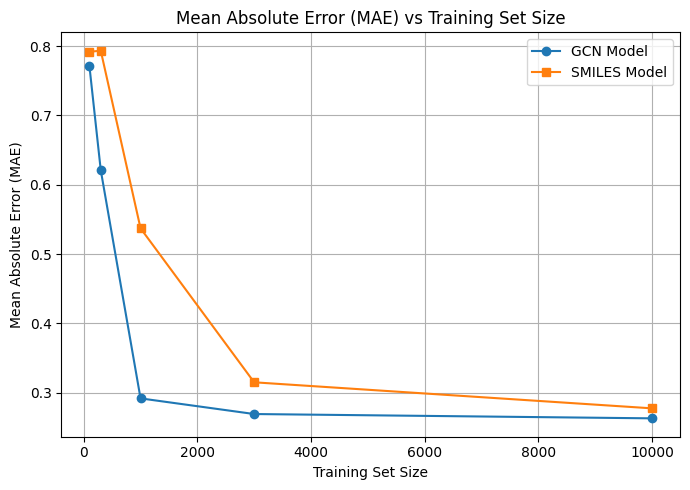

Plot saved to task2_r2_plot.png


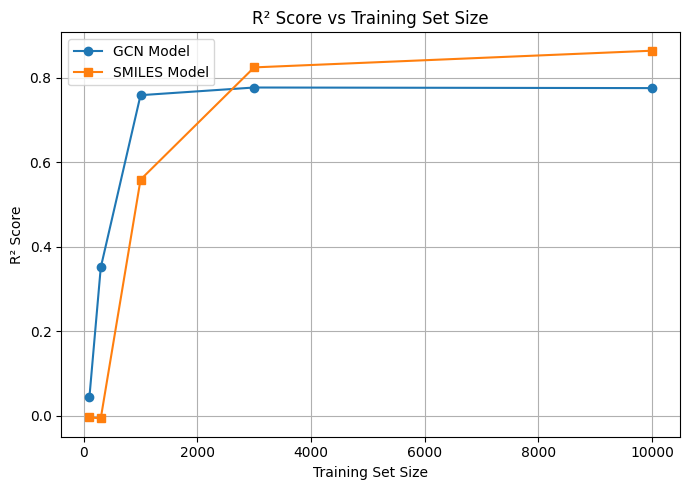

In [ ]:
def plot_metric(results_gcn, results_smiles, metric, ylabel, filename=None):
    sizes = sorted(results_gcn.keys())
    gcn_values = [results_gcn[s][metric] for s in sizes]
    smiles_values = [results_smiles[s][metric] for s in sizes]

    plt.figure(figsize=(7, 5))
    plt.plot(sizes, gcn_values, marker='o', label='GCN Model')
    plt.plot(sizes, smiles_values, marker='s', label='SMILES Model')
    plt.xlabel("Training Set Size")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs Training Set Size")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
        print(f"Plot saved to {filename}")
    plt.show()

# Plot using collected results
plot_metric(gcn_results, smiles_results, metric="MAE", ylabel="Mean Absolute Error (MAE)", filename="task2_mae_plot.png")
plot_metric(gcn_results, smiles_results, metric="R2", ylabel="R² Score", filename="task2_r2_plot.png")



## Task 3


In [ ]:
# Setting variables
skip_training = True
MODEL_PATH = "smiles_model_task3.pth"
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

def tokenize_smiles(smiles):
    return list(smiles)

def build_vocab(smiles_list):
    special_tokens = ['<pad>', '<sos>', '<eos>']
    all_chars = sorted(set(''.join(smiles_list)))
    itos = special_tokens + all_chars
    stoi = {s: i for i, s in enumerate(itos)}
    return stoi, itos


In [51]:
class SmilesDataset(Dataset):
    def __init__(self, smiles_list, stoi, max_len=120):
        self.stoi = stoi
        self.itos = {i: s for s, i in stoi.items()}
        self.max_len = max_len
        self.pad_idx = self.stoi['<pad>']
        self.sos_idx = self.stoi['<sos>']
        self.eos_idx = self.stoi['<eos>']
        self.data = [self.encode(s) for s in smiles_list]

    def encode(self, s):
        tokens = ['<sos>'] + tokenize_smiles(s) + ['<eos>']
        ids = [self.stoi[c] for c in tokens]
        if len(ids) < self.max_len:
            ids += [self.pad_idx] * (self.max_len - len(ids))
        return ids[:self.max_len]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx], dtype=torch.long)
        return seq[:-1], seq[1:]  # input, target


In [52]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [53]:
canonicalize("COO"), canonicalize("O(C)O")

('COO', 'COO')

In [54]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(True, True, False)

In [55]:
class SmilesLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.1, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded, hidden)
        logits = self.output(out)
        return logits, hidden

## Training Loop


In [56]:
def train_model(model, train_dataset, stoi, epochs=10, batch_size=64, lr=1e-3,
                device='cuda' if torch.cuda.is_available() else 'cpu'):

    batch_size = 256 if torch.cuda.is_available() else 64
    pad_idx = stoi['<pad>']
    model = model.to(device)

    if skip_training:
      print("Skipping training. Loading saved model weights...")
      model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
      model = model.to(device)
      return model

    model.train()
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

    for epoch in range(1, epochs+1):
        total_loss = 0.0
        loop = tqdm(loader, desc=f"Epoch {epoch}")
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)

            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch} completed. Avg Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")
    return model


In [57]:
train_smiles = [smiles_data[i] for i in train_idxes]
stoi, itos = build_vocab(train_smiles)
train_dataset = SmilesDataset(train_smiles, stoi, max_len=120)

model = SmilesLSTMModel(
    vocab_size=len(stoi),
    embed_dim=256,
    hidden_dim=512,
    num_layers=2,
    dropout=0.1,
    pad_idx=stoi['<pad>']
)

model = train_model(model, train_dataset, stoi, epochs=10)



Skipping training. Loading saved model weights...


### Sampling


In [58]:
def sample_smiles(model, stoi, itos, max_length=120, temperature=1.0, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    generated = []
    sos_idx = stoi['<sos>']
    eos_idx = stoi['<eos>']

    with torch.no_grad():
        input_seq = torch.tensor([[sos_idx]], dtype=torch.long).to(device)
        hidden = None

        for _ in range(max_length):
            logits, hidden = model(input_seq, hidden)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            next_idx = next_token.item()

            if next_idx == eos_idx:
                break

            generated.append(itos[next_idx])
            input_seq = next_token

    return ''.join(generated)


In [59]:
def generate_smiles_batch(model, stoi, itos, n=5000, temperature=1.0):
    samples = []
    for _ in tqdm(range(n), desc="Generating SMILES"):
        smi = sample_smiles(model, stoi, itos, temperature=temperature)
        samples.append(smi)
    return samples


### Evaluation


In [60]:
def evaluate_smiles(generated_smiles, train_smiles):
    train_set = set([canonicalize(s) for s in train_smiles])
    valid_smiles = []
    canonical_valid = []

    for smi in generated_smiles:
        if is_valid_smiles(smi):
            can = canonicalize(smi)
            if can != 'None':
                valid_smiles.append(smi)
                canonical_valid.append(can)

    total_generated = len(generated_smiles)
    total_valid = len(valid_smiles)
    unique_valid = len(set(canonical_valid))
    novel_valid = len([s for s in set(canonical_valid) if s not in train_set])

    return {
        "validity": total_valid / total_generated * 100,
        "uniqueness": unique_valid / total_valid * 100 if total_valid > 0 else 0,
        "novelty": novel_valid / total_valid * 100 if total_valid > 0 else 0,
    }


In [ ]:
samples = generate_smiles_batch(model, stoi, itos, n=5000, temperature=0.9)
metrics = evaluate_smiles(samples, train_smiles)
print("Evaluation Results:")
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v:.2f}%")

with open("generated_smiles.txt", "w") as f:
    for smi in samples:
        f.write(smi + "\n")


Generating SMILES: 100%|██████████| 5000/5000 [00:29<00:00, 168.43it/s]


Evaluation Results:
Validity: 98.48%
Uniqueness: 97.26%
Novelty: 29.85%
